In [18]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.window import Window
from sklearn import preprocessing # https://github.com/Snowflake-Labs/snowpark-python-demos/tree/main/sp4py_utilities
from snowflake.snowpark.functions import col

import getpass
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
accountname = 'ex39201.ap-southeast-1'
username = getpass.getpass()    # SNOWFLAKE-USERNAME
password = getpass.getpass()    # SNOWFLAKE-PASSWORD

In [20]:
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    "database": "FROSTBYTE_TASTY_BYTES",
    "warehouse": "TASTY_DATA_APP_WH"
}

session = Session.builder.configs(connection_parameters).create()

In [21]:
import calendar

def get_dates(year, month):
    # Get the number of days in the given month
    num_days = calendar.monthrange(year, month)[1]
    # Generate a list of dates for the given month and year
    dates = [f"{year}-{month:02d}-{day:02d}" for day in range(1, num_days + 1)]
    return dates

In [22]:
import datetime
import holidays
def add_public_holiday_column(df, date_column):
    # Create an instance of the holiday class for the appropriate country
    country_code = 'US'  # Replace with the appropriate country code
    holiday_list = holidays.CountryHoliday(country_code)

    # Convert the date column to datetime if it's not already in that format
    df[date_column] = pd.to_datetime(df[date_column])

    # Create a new column "PUBLIC_HOLIDAY" and set initial values to 0
    df['PUBLIC_HOLIDAY'] = 0

    # Iterate over each date in the date column
    for date in df[date_column]:
        # Check if the date is a public holiday
        if date in holiday_list:
            # Set the value of "PUBLIC_HOLIDAY" to 1 if it is a public holiday
            df.loc[df[date_column] == date, 'PUBLIC_HOLIDAY'] = 1

    return df

In [23]:
def get_location_id(truck_id):
    #schema get Truck table + Location table, get location id, City + region
    session.use_schema("RAW_POS")
    query = "SELECT PRIMARY_CITY FROM TRUCK WHERE TRUCK_ID = {}".format(truck_id)
    city_df=session.sql(query).toPandas()
    city = city_df['PRIMARY_CITY'].iloc[0]

    query = "SELECT LOCATION_ID FROM LOCATION WHERE CITY = '{}'".format(city)
    location_df=session.sql(query).toPandas()
    location_df['TRUCK_ID'] = truck_id
    return location_df

In [24]:
def get_hours_df(truck_id):
    # Create a list of hours from 0 to 23
    hours = list(range(24))
    # Create a dictionary with column names and corresponding data
    data = {'TRUCK_ID': [truck_id] * 24, 'HOUR': hours}
    # Create a new dataframe from the dictionary
    new_df = pd.DataFrame(data)
    return new_df

In [25]:
def upload_input_data_to_snowflake():
    session.use_schema("ANALYTICS")
    X_final_scaled=session.sql('Select * from "Sales_Forecast_Training_Data"').to_pandas()
    X_final_scaled.rename(columns={"Profit": "Revenue"},inplace=True)
    sales_pred=session.sql("select * from ANALYTICS.SALES_PREDICTION").to_pandas()
    X_final_scaled=X_final_scaled.merge(sales_pred["l_w5i8_DATE"].astype(str).str[:4].rename('YEAR'), left_index=True, right_index=True)

    truck_ids = [27, 28, 43, 44, 46, 47]
    years = ['2020', '2021', '2022']
    X_final_scaled = X_final_scaled[(X_final_scaled['TRUCK_ID'].isin(truck_ids)) & (X_final_scaled['YEAR'].isin(years))]

    session.use_schema("ANALYTICS")
    weadf=session.sql('select * from "weadf_trend"').to_pandas()
    weadf['DATE'] = pd.to_datetime(weadf['DATE'])

    for truck in truck_ids:
        for year in years:
            for month in range(1,13):
                current_df = X_final_scaled[(X_final_scaled['TRUCK_ID'] == truck) & (X_final_scaled['MONTH'] == month) & (X_final_scaled['YEAR'] == year)]
                
                current_dates = get_dates(int(year),month)
                main_df = pd.DataFrame({'TRUCK_ID': [truck] * len(current_dates),'DATE': current_dates})
                main_df = add_public_holiday_column(main_df, 'DATE')
                main_df = pd.merge(main_df, get_location_id(truck),  how='left', left_on='TRUCK_ID', right_on ='TRUCK_ID').drop_duplicates()
                main_df = pd.merge(main_df, get_hours_df(truck),  how='left', left_on='TRUCK_ID', right_on ='TRUCK_ID').drop_duplicates()
                main_df = pd.merge(main_df, weadf,  how='left', left_on=['LOCATION_ID','HOUR','DATE'], right_on =['LOCATION_ID','H','DATE']).drop_duplicates()
                main_df = main_df.drop('H', axis=1).drop_duplicates().dropna()
                
                main_df['DATE'] = pd.to_datetime(main_df['DATE'])
                main_df['MONTH'] = main_df['DATE'].dt.month
                main_df['DOW'] = main_df['DATE'].dt.weekday
                main_df['DAY'] = main_df['DATE'].dt.day
                main_df['YEAR'] = main_df['DATE'].dt.year
                main_df['DATE'] = main_df['DATE'].astype(str)

                encoded_X = current_df[['TRUCK_ID','MENU_TYPE_GYROS_ENCODED', 'MENU_TYPE_CREPES_ENCODED', 'MENU_TYPE_BBQ_ENCODED', 'MENU_TYPE_SANDWICHES_ENCODED', 'MENU_TYPE_Mac & Cheese_encoded', 'MENU_TYPE_POUTINE_ENCODED', 'MENU_TYPE_ETHIOPIAN_ENCODED', 'MENU_TYPE_TACOS_ENCODED', 'MENU_TYPE_Ice Cream_encoded', 'MENU_TYPE_Hot Dogs_encoded', 'MENU_TYPE_CHINESE_ENCODED', 'MENU_TYPE_Grilled Cheese_encoded', 'MENU_TYPE_VEGETARIAN_ENCODED', 'MENU_TYPE_INDIAN_ENCODED', 'MENU_TYPE_RAMEN_ENCODED', 'CITY_SEATTLE_ENCODED', 'CITY_DENVER_ENCODED', 'CITY_San Mateo_encoded', 'CITY_New York City_encoded', 'CITY_BOSTON_ENCODED', 'REGION_NY_ENCODED', 'REGION_MA_ENCODED', 'REGION_CO_ENCODED', 'REGION_WA_ENCODED', 'REGION_CA_ENCODED']].drop_duplicates()
                main_df = pd.merge(main_df, encoded_X,  how='left', left_on=['TRUCK_ID'], right_on =['TRUCK_ID']).drop_duplicates()
                sum_X = current_df[['TRUCK_ID','MONTH','HOUR','DAY','SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', 'SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE']]
                main_df = pd.merge(main_df, sum_X,  how='left', left_on=['TRUCK_ID','HOUR','MONTH','DAY'], right_on =['TRUCK_ID','HOUR','MONTH','DAY']).drop_duplicates()

                main_df = main_df.fillna({ 'SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE':(main_df['SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE'].mean())})
                main_df = main_df.fillna({ 'SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE':(main_df['SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE'].mean())})

                session.write_pandas(
                    df=main_df,
                    table_name="Trend_Input_Data",
                    database="FROSTBYTE_TASTY_BYTES",
                    schema="ANALYTICS",
                    quote_identifiers=True,
                    overwrite=False
                )

                if year == '2022':
                    if month == 10:
                        break

In [26]:
def generate_month_list(start_month, start_year, end_month, end_year):
    start_date = datetime.date(start_year, start_month, 1)
    end_date = datetime.date(end_year, end_month, 1)
    month_list = []

    while start_date <= end_date:
        month_list.append(start_date.month)
        start_date += datetime.timedelta(days=32)
        start_date = start_date.replace(day=1)

    return month_list

In [27]:
def get_shift_durations(start_hour,end_hour,num_of_locs):
    starting_hour = start_hour
    ending_hour = end_hour
    working_hours = ending_hour - starting_hour
    # Calculate the base shift hours (without considering the remainder)
    shift_hours = working_hours // num_of_locs
    # Calculate the remaining hours to distribute
    remaining_hours = working_hours % num_of_locs

    # Create a list to store the shift hours for each shift
    shift_hours_list = [shift_hours] * num_of_locs

    # Distribute the remaining hours evenly across shifts
    for i in range(remaining_hours):
        shift_hours_list[i] += 1

    return shift_hours_list

In [28]:
def get_shift_hours(start_hour, end_hour, num_of_locs):
    starting_hour = start_hour
    ending_hour = end_hour
    working_hours = ending_hour - starting_hour

    # Calculate the base shift hours (without considering the remainder)
    shift_hours = working_hours // num_of_locs

    # Calculate the remaining hours to distribute
    remaining_hours = working_hours % num_of_locs

    # Create a list to store the shift hour arrays
    shift_hours_list = []

    # Calculate the shift hours for each shift
    current_hour = starting_hour
    for i in range(num_of_locs):
        # Calculate the end hour for the current shift
        end_shift_hour = current_hour + shift_hours

        # Add the hours for the current shift to the list
        shift_hours_list.append(list(range(current_hour, end_shift_hour)))

        # Adjust the current hour for the next shift
        current_hour = end_shift_hour

        # Distribute remaining hours evenly across shifts
        if remaining_hours > 0:
            shift_hours_list[i].append(current_hour)
            current_hour += 1
            remaining_hours -= 1

    return shift_hours_list

In [29]:
import math
def haversine_distance(df, max_distance):
    # Copy the input DataFrame to avoid modifying the original
    df = df.copy()
    
    # Convert latitude and longitude from degrees to radians
    df['LAT_rad'] = df['LAT'].apply(math.radians)
    df['LONG_rad'] = df['LONG'].apply(math.radians)
    df['LAT2_rad'] = df['LAT2'].apply(math.radians)
    df['LONG2_rad'] = df['LONG2'].apply(math.radians)

    # Haversine formula
    df['dlon'] = df['LONG2_rad'] - df['LONG_rad']
    df['dlat'] = df['LAT2_rad'] - df['LAT_rad']
    df['a'] = (df['dlat'] / 2).apply(math.sin)**2 + df['LAT_rad'].apply(math.cos) * df['LAT2_rad'].apply(math.cos) * (df['dlon'] / 2).apply(math.sin)**2
    df['c'] = 2 * df['a'].apply(lambda x: math.atan2(math.sqrt(x), math.sqrt(1 - x)))
    df['DISTANCE'] = 6371 * df['c']  # Radius of the Earth in kilometers

    # Filter rows based on max_distance
    df = df[df['DISTANCE'] <= max_distance]

    # Drop intermediate columns
    df.drop(['LAT_rad', 'LONG_rad', 'LAT2_rad', 'LONG2_rad', 'dlon', 'dlat', 'a', 'c'], axis=1, inplace=True)

    # Reset the index of the resulting DataFrame
    df.reset_index(drop=True, inplace=True)

    return df

In [30]:
def get_highest_predicted(df):
    # Group by "id" and "day" and calculate the sum of "predicted"
    summed_df = df.groupby(["LOCATION_ID", "DAY"])["Predicted"].sum().reset_index()
    
    # Find the maximum summed predicted value for each day
    max_predicted_df = summed_df.groupby("DAY")["Predicted"].max().reset_index()
    
    # Merge with the original DataFrame to get the corresponding "id"
    result_df = pd.merge(max_predicted_df, summed_df, on=["DAY", "Predicted"])
    
    return result_df

In [31]:
truck_ids = [27, 28, 43, 44, 46, 47]
years = ['2020', '2021', '2022']
#upload_input_data_to_snowflake()

In [32]:
import joblib
xgb = joblib.load('model.joblib')

In [33]:
truck_id = 46
start_year = 2020
start_month = 1
end_year = 2020
end_month = 12
start_hour = 8
end_hour = 16
num_of_locs = 3
each_location_travel_distance = 15 #km
work_days = [0,2,4]

max_total_travel_distance= each_location_travel_distance * num_of_locs
months_list = generate_month_list(start_month, start_year, end_month, end_year)
hours_list = list(range(start_hour, end_hour + 1))

#Day of week, 0 is Monday, 1 is Tuesday, etc

#Truck_ID, Has TRUCK_IDS 27, 28, 43, 44, 46, 47
#Time Frame, start + end date select only month to month, minimum 3 months maximum 1 year, YEARS 2020, 2021, 2022
#Starting Hour, Ending Hour max 18 hours?
#Week Work Days #Mon-Sun
#Num_of_locations Max 8?
#Location Travel Distance no limit
#up until Oct 2022

In [34]:
year = start_year
shift_hours_list = get_shift_hours(start_hour,end_hour,num_of_locs)
month_value_list = []
final_df = pd.DataFrame()
session.use_schema("ANALYTICS")

for month in months_list:
    if start_year != end_year:
        if month == 1:
            year += 1

    query = 'SELECT * FROM "Trend_Input_Data" WHERE TRUCK_ID = {} AND YEAR = {} AND MONTH = {} AND HOUR IN ({}) AND DOW IN ({})'.format(
        truck_id, year, month, ', '.join(map(str, hours_list)), ', '.join(map(str, work_days)))
    input_data=session.sql(query).to_pandas()

    predict_df = input_data[['TRUCK_ID', 'HOUR', 'MONTH', 'DOW', 'DAY', 'PUBLIC_HOLIDAY', 'LAT', 'LONG', 'LOCATION_ID', 'SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', 'SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE', 
                            'WEATHERCODE', 'MENU_TYPE_GYROS_ENCODED', 'MENU_TYPE_CREPES_ENCODED', 'MENU_TYPE_BBQ_ENCODED', 'MENU_TYPE_SANDWICHES_ENCODED', 'MENU_TYPE_Mac & Cheese_encoded', 'MENU_TYPE_POUTINE_ENCODED', 
                            'MENU_TYPE_ETHIOPIAN_ENCODED', 'MENU_TYPE_TACOS_ENCODED', 'MENU_TYPE_Ice Cream_encoded', 'MENU_TYPE_Hot Dogs_encoded', 'MENU_TYPE_CHINESE_ENCODED', 'MENU_TYPE_Grilled Cheese_encoded', 
                            'MENU_TYPE_VEGETARIAN_ENCODED', 'MENU_TYPE_INDIAN_ENCODED', 'MENU_TYPE_RAMEN_ENCODED', 'CITY_SEATTLE_ENCODED', 'CITY_DENVER_ENCODED', 'CITY_San Mateo_encoded', 'CITY_New York City_encoded', 
                            'CITY_BOSTON_ENCODED', 'REGION_NY_ENCODED', 'REGION_MA_ENCODED', 'REGION_CO_ENCODED', 'REGION_WA_ENCODED', 'REGION_CA_ENCODED']]
    predict_df['Predicted'] = xgb.predict(predict_df)

    shifts_df_list = []
    value = 0
    for i in range(num_of_locs):
        current_shift = predict_df[predict_df['HOUR'].isin(shift_hours_list[i])]

        if i > 0:
            previous_shift = pd.merge(shifts_df_list[i-1], predict_df[["LOCATION_ID",'LAT','LONG']].drop_duplicates(), on=["LOCATION_ID"])
            previous_shift.rename(columns={'LAT': 'LAT2', 'LONG': 'LONG2'}, inplace=True)
            current_shift = pd.merge(current_shift, previous_shift[['LAT2','LONG2','DAY']], on=['DAY']).drop_duplicates()
            current_shift = haversine_distance(current_shift, each_location_travel_distance)
        
        highest_df = get_highest_predicted(current_shift)
        value += highest_df['Predicted'].sum()
        shifts_df_list.append(highest_df)
        highest_df['HOUR'] = shift_hours_list[i][0]
        highest_df['MONTH'] = month
        highest_df['YEAR'] = year
        final_df = pd.concat([final_df, highest_df])

    month_value_list.append(value)

C:\Users\Jammie99\AppData\Local\Temp\ipykernel_5864\2558251365.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['Predicted'] = xgb.predict(predict_df)
C:\Users\Jammie99\AppData\Local\Temp\ipykernel_5864\2558251365.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['Predicted'] = xgb.predict(predict_df)
C:\Users\Jammie99\AppData\Local\Temp\ipykernel_5864\2558251365.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

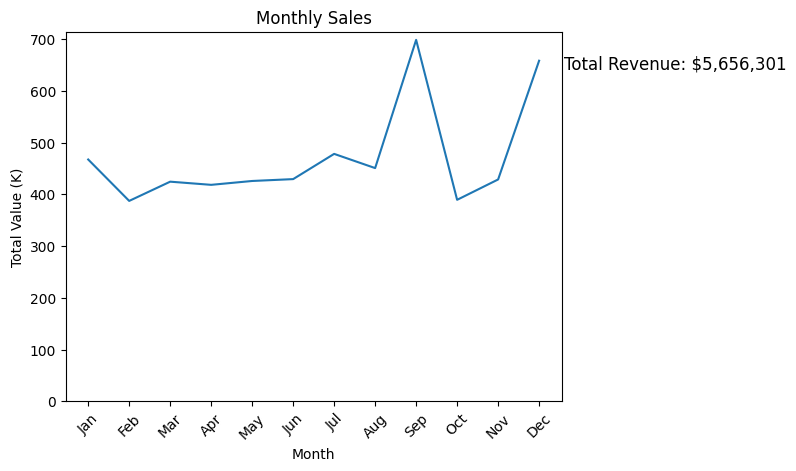

In [35]:
import matplotlib.pyplot as plt
import calendar

# Create DataFrame
monthly_df = pd.DataFrame({
    'Months': months_list,
    'Value': month_value_list})

# Convert months to three-letter abbreviations
monthly_df['Months'] = monthly_df['Months'].apply(lambda x: calendar.month_abbr[x])

# Calculate the total revenue
total_revenue = monthly_df['Value'].sum()
total_revenue = f'{total_revenue:,.0f}'

# Convert value to thousands (K)
monthly_df['Value'] = monthly_df['Value'] / 1000

# Plot time series line chart
plt.plot(monthly_df['Months'], monthly_df['Value']) 
plt.xlabel('Month')
plt.ylabel('Total Value (K)')
plt.title('Monthly Sales')
plt.xticks(rotation=45)

# Add total revenue annotation
plt.annotate(f'Total Revenue: ${total_revenue}', xy=(1.005, 0.9), xycoords='axes fraction', fontsize=12)

# Set y-axis limits
plt.ylim(0)

plt.show()